# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

When solving this task, we expect you'll face (and successfully deal with) some problems or make up the ideas of the model improvement. Some of them are:

- solving a problem of n-grams frequencies storing for a large corpus;
- taking into account keyboard layout and associated misspellings;
- efficiency improvement to make the solution faster;
- ...

Please don't forget to describe such cases, and what you decided to do with them, in the Justification section.

##### IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

In [1]:
import re
import math
from collections import Counter

# Define keyboard layout adjacency dictionary.
KEYBOARD_NEIGHBORS = {
    'q': "was",
    'w': "qeasd",
    'e': "wrsdf",
    'r': "etdfg",
    't': "ryfgh",
    'y': "tughj",
    'u': "yihjk",
    'i': "uojkl",
    'o': "ipkl",
    'p': "ol",
    'a': "qwszx",
    's': "qweadzxc",
    'd': "wersfxcv",
    'f': "ertdgcvb",
    'g': "rtyfhvbn",
    'h': "tyugjbnm",
    'j': "yuihknm",
    'k': "uiojlm",
    'l': "iopk;.,",
    'z': "asx",
    'x': "asdzc",
    'c': "sdfxv",
    'v': "dfgcb",
    'b': "fghvn",
    'n': "ghjbm",
    'm': "hjkn,",
    ';': "lop['/.,]"
}

def words(text):
    return re.findall(r'\w+', text.lower())

# Load unigram frequencies from a corpus.
WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] + 1 / N

# Load bigram frequencies from a dataset.
# Assumes a file "bigram.txt" with each line: word1 word2 count
BIGRAMS = Counter()
with open('bigrams (2).txt', encoding='latin-1') as f:
    for line in f:
        parts = line.split()
        if len(parts) == 3:
            count, w1, w2  = parts
            BIGRAMS[(w1, w2)] = int(count)

def bigram_prob(w1, w2):
    """
    Returns the probability P(w2|w1) using add‑one (Laplace) smoothing.
    """
    V = len(WORDS)  # vocabulary size
    return (BIGRAMS[(w1, w2)] + 1) / (WORDS[w1] + V)

def keyboard_distance(s, t):
    """
    Compute a weighted edit distance between s and t.
    Substitutions with a neighbor key cost 0.5, other substitutions cost 1.
    Insertions and deletions cost 1.
    """
    m, n = len(s), len(t)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s[i-1] == t[j-1]:
                cost = 0
            else:
                # Lower cost if the substitution is with a neighbor key.
                cost = 0.5 if t[j-1] in KEYBOARD_NEIGHBORS.get(s[i-1], '') else 1
            dp[i][j] = min(dp[i-1][j] + 1,     # deletion
                           dp[i][j-1] + 1,     # insertion
                           dp[i-1][j-1] + cost)  # substitution
    return dp[m][n]

def correction(word):
    """
    Most probable spelling correction for a single word, combining frequency
    and a penalty based on keyboard-distance.
    """
    return max(candidates(word),
               key=lambda w: P(w) / (1 + keyboard_distance(word, w)))

def candidates(word):
    "Generate possible spelling corrections for word."
    return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]

def known(words_list):
    "Return the subset of words_list that appear in the dictionary."
    return set(w for w in words_list if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`, including keyboard neighbor-based replacements."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    # Only use adjacent keys for neighbor-based replacements.
    replaces   = [L + c + R[1:] for L, R in splits if R for c in KEYBOARD_NEIGHBORS.get(R[0], '')]
    inserts    = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence, beam_width=3):
    """
    Corrects a multi-word sentence using beam search with a bigram language model.

    Each candidate sequence is scored with the sum of log probabilities.
    For the first word, we use the unigram probability; for subsequent words, we use
    the bigram probability P(w_i|w_{i-1}). In both cases, we subtract a penalty based on
    the keyboard edit distance between the original and candidate word.
    """
    words_in_sentence = sentence.split()
    # Each element in the beam is a tuple: (score, [list of corrected words])
    beam = [(0.0, [])]
    for orig_word in words_in_sentence:
        new_beam = []
        for score, seq in beam:
            prev_word = seq[-1] if seq else None
            for cand in candidates(orig_word):
                # Apply a penalty for edit distance.
                penalty = -math.log(1 + keyboard_distance(orig_word, cand))
                if prev_word is None:
                    prob = P(cand)
                    if prob == 0:
                        continue
                    cand_score = math.log(prob) + penalty
                else:
                    prob = bigram_prob(prev_word, cand)
                    cand_score = math.log(prob) + penalty
                new_score = score + cand_score
                new_seq = seq + [cand]
                new_beam.append((new_score, new_seq))
        # Keep only the top beam_width candidate sequences.
        beam = sorted(new_beam, key=lambda x: x[0], reverse=True)[:beam_width]
    best_score, best_seq = beam[0]
    return ' '.join(best_seq)

# Example usage:
if __name__ == "__main__":
    sentence = "speling errurs in somethink"
    print("Original sentence: ", sentence)
    print("Corrected sentence:", correct_sentence(sentence))


Original sentence:  speling errurs in somethink
Corrected sentence: spelling errors in something


## Justify your decisions

Write down justificaitons for your implementation choices. For example, these choices could be:
- Which ngram dataset to use
- Which weights to assign for edit1, edit2 or absent words probabilities
- Beam search parameters
- etc.

## Bigram Models
- Uses a large corpus (`big.txt`) and bigram frequencies (with add‑one smoothing) to estimate word likelihood and context.
- We chose to use Bigrams instead of 5-grams due to it's simplicity which is related to most google queries from usual users.


## Weighted Edit Distance
- Neighbor key substitutions cost 0.5 (others cost 1) to reflect common typing errors. So mistyping ; instead of l is 0.5, but mistyping f instead of l is 1.

## Candidate Generation
- Checks for known words, then one- and two-edit-away candidates to balance efficiency with error coverage as candidates grow exponentially with steps-of-edit.

## Beam Search
- A beam width of 3 provides a good trade-off between exploring context and keeping computations manageable.


## Evaluate on a test set

Your task is to generate a test set and evaluate your work. You may vary the noise probability to generate different datasets with varying compexity (or just take another dataset). Compare your solution to the Norvig's corrector, and report the accuracies.

In [2]:
sentences = """how to make pizza
best coffee near me
weather in London today
how to learn Python
buy headphones online
cheap flights to Paris
restaurants open now
top movies 2025
nearest gym to me
how to start a blog
where to buy shoes
what is AI
best vacation spots
how to lose weight
best smartphone 2025
how to play chess
best books for kids
how to fix a car
new iPhone release date
best online courses
how to study effectively
when is the next holiday
how to meditate
best laptop for gaming
how to grow tomatoes
top travel destinations
how to improve writing skills
cheap hotels in London
how to save money
how to make friends
best restaurants in NYC
how to organize a party
how to make ice cream
best streaming service 2025
how to fix a leaky faucet
where to buy a bicycle
how to learn English
best apps for productivity
how to start a business
how to fix a broken phone"""

# Save to a .txt file
with open("synthetic_queries.txt", "w") as file:
    file.write(sentences)

print("Text file saved successfully.")


Text file saved successfully.


In [3]:
import re
import random
import string

def extract_sentences(filename):
    """Load sentences from a text file into a list."""
    with open(filename, 'r', encoding='utf-8') as file:
        sentences = file.read().splitlines()  # Each line is a sentence
    return sentences


import random
import string

# Define QWERTY neighbors for lowercase letters.
qwerty_neighbors = {
    'q': ['w', 'a'],
    'w': ['q', 'e', 's'],
    'e': ['w', 'r', 'd'],
    'r': ['e', 't', 'f'],
    't': ['r', 'y', 'g'],
    'y': ['t', 'u', 'h'],
    'u': ['y', 'i', 'j'],
    'i': ['u', 'o', 'k'],
    'o': ['i', 'p', 'l'],
    'p': ['o'],
    'a': ['q', 's', 'z'],
    's': ['a', 'd', 'w', 'x'],
    'd': ['s', 'f', 'e', 'c'],
    'f': ['d', 'g', 'r', 'v'],
    'g': ['f', 'h', 't', 'b'],
    'h': ['g', 'j', 'y', 'n'],
    'j': ['h', 'k', 'u', 'm'],
    'k': ['j', 'l', 'i'],
    'l': ['k', 'o'],
    'z': ['a', 'x'],
    'x': ['z', 'c', 's'],
    'c': ['x', 'v', 'd'],
    'v': ['c', 'b', 'f'],
    'b': ['v', 'n', 'g'],
    'n': ['b', 'm', 'h'],
    'm': ['n', 'j']
}

def inject_noise(word, noise_probability=0.2):
    """
    Inject random noise into a word while taking into account QWERTY key positions.

    Operations:
      - substitute: replace a character with one of its nearby keys
      - delete: remove the character
      - insert: insert a neighbor key before the character
      - transpose: swap with the next character
    """
    result = []
    i = 0
    while i < len(word):
        if random.random() < noise_probability:
            choices = ['substitute', 'delete', 'insert', 'transpose']
            probs = [0.4, 0.3, 0.2, 0.1]
            op = random.choices(choices, weights=probs, k=1)[0]
            current_char = word[i]
            lower_char = current_char.lower()
            # Use neighbors if available; otherwise fall back to a random lowercase letter.
            neighbors = qwerty_neighbors.get(lower_char, list(string.ascii_lowercase))

            if op == 'substitute':
                # Substitute with a neighbor key.
                new_char = random.choice(neighbors)
                # Preserve case if necessary.
                if current_char.isupper():
                    new_char = new_char.upper()
                result.append(new_char)
                i += 1
            elif op == 'delete':
                # Simply skip the current character.
                i += 1
            elif op == 'insert':
                # Insert a neighbor before the current character.
                ins_char = random.choice(neighbors)
                if current_char.isupper():
                    ins_char = ins_char.upper()
                result.append(ins_char)
                result.append(current_char)
                i += 1
            elif op == 'transpose' and i < len(word) - 1:
                # Swap current and next characters.
                result.append(word[i + 1])
                result.append(current_char)
                i += 2
            else:
                # Fallback: no operation.
                result.append(current_char)
                i += 1
        else:
            result.append(word[i])
            i += 1
    return ''.join(result)


def inject_noise_sentence(sentence, noise_probability=0.2):
    """Apply noise injection to each word in the sentence."""
    return ' '.join(inject_noise(word, noise_probability) for word in sentence.split())

def create_datasets(filename, noise_levels=[0.05, 0.1, 0.15]):
    """Create and save datasets with different noise probabilities."""
    sentences = extract_sentences(filename)

    # Save original sentences
    with open("original_sentences.txt", 'w', encoding='utf-8') as file:
        file.write('\n'.join(sentences))
    print("Original sentences saved to original_sentences.txt")

    # Create noisy datasets
    for noise_level in noise_levels:
        noisy_sentences = [inject_noise_sentence(sentence, noise_level) for sentence in sentences]
        output_filename = f"dataset_noise_{noise_level}.txt"
        with open(output_filename, 'w', encoding='utf-8') as file:
            file.write('\n'.join(noisy_sentences))

        print(f"Dataset with noise probability {noise_level} saved to {output_filename}")


# Run the function
create_datasets('synthetic_queries.txt')


Original sentences saved to original_sentences.txt
Dataset with noise probability 0.05 saved to dataset_noise_0.05.txt
Dataset with noise probability 0.1 saved to dataset_noise_0.1.txt
Dataset with noise probability 0.15 saved to dataset_noise_0.15.txt


In [4]:
def load_sentences(filename):
    """Load sentences from a text file into a list."""
    with open(filename, 'r', encoding='utf-8') as file:
        sentences = file.read().splitlines()  # Each line is a sentence
    return sentences

# Example usage
noisy_sentences1 = load_sentences('dataset_noise_0.05.txt')
noisy_sentences2 = load_sentences('dataset_noise_0.1.txt')
noisy_sentences3 = load_sentences('dataset_noise_0.15.txt')
gt_sentences = load_sentences('original_sentences.txt')

# Print the first 5 sentences
for i, sentence in enumerate(noisy_sentences1[:5], start=1):
    print(f"{i}. {sentence}")


1. ho to mzake pizaz
2. best coffew near me
3. weather in London today
4. how to learn Python
5. buy heafphones online


In [5]:

# Print the first 5 sentences
for i, sentence in enumerate(noisy_sentences1[:5], start=1):
    print(f"{i}. {sentence}")


1. ho to mzake pizaz
2. best coffew near me
3. weather in London today
4. how to learn Python
5. buy heafphones online


In [6]:
# base solution
# Your code here
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] / N

def correction(word):
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence):
    """Corrects a full sentence by applying the correction function to each word."""
    return ' '.join(correction(word) for word in sentence.split())


In [7]:
sentence = "spe;;ing errurs in somethink"
correct_sentence(sentence)

'speaking errors in something'

In [8]:
import re
import random
import string
from collections import Counter
from tqdm.notebook import tqdm

# ---------------------------
# Evaluation on a Test Set
# ---------------------------

def evaluate_on_test_set(test_sentences, gt_sentences):
    """Generates a test set by adding noise and correcting them."""
    random.seed(42)
    total_words, correct_words = 0, 0
    total_sentences, correct_sentences = len(test_sentences), 0

    for idx, sentence in tqdm(enumerate(test_sentences)):
        corrected = correct_sentence(sentence)
        gt_sentence = gt_sentences[idx]
        original_words, corrected_words = gt_sentence.split(), corrected.split()

        total_words += len(original_words)
        correct_words += sum(ow == cw for ow, cw in zip(original_words, corrected_words))

        if gt_sentence == corrected:
            correct_sentences += 1

        # print(f"Original:   {sentence}\nNoisy:      {noised}\nCorrected:  {corrected}\n{'-' * 40}")

    word_accuracy = correct_words / total_words * 100 if total_words else 0
    sentence_accuracy = correct_sentences / total_sentences * 100 if total_sentences else 0

    print(f"Word-level accuracy: {word_accuracy:.2f}%")
    print(f"Sentence-level accuracy: {sentence_accuracy:.2f}%\n")
    return word_accuracy, sentence_accuracy

# ---------------------------
# Main Evaluation
# ---------------------------

if __name__ == "__main__":
    solution1_level1_wa, solution1_level1_sa = evaluate_on_test_set(noisy_sentences1, gt_sentences)
    solution1_level2_wa, solution1_level2_sa = evaluate_on_test_set(noisy_sentences2, gt_sentences)
    solution1_level3_wa, solution1_level3_sa = evaluate_on_test_set(noisy_sentences3, gt_sentences)


0it [00:00, ?it/s]

Word-level accuracy: 79.14%
Sentence-level accuracy: 35.00%



0it [00:00, ?it/s]

Word-level accuracy: 71.17%
Sentence-level accuracy: 27.50%



0it [00:00, ?it/s]

Word-level accuracy: 66.87%
Sentence-level accuracy: 15.00%



## testing our algorithm

In [9]:
import re
import math
from collections import Counter

# Define keyboard layout adjacency dictionary.
KEYBOARD_NEIGHBORS = {
    'q': "was",
    'w': "qeasd",
    'e': "wrsdf",
    'r': "etdfg",
    't': "ryfgh",
    'y': "tughj",
    'u': "yihjk",
    'i': "uojkl",
    'o': "ipkl",
    'p': "ol",
    'a': "qwszx",
    's': "qweadzxc",
    'd': "wersfxcv",
    'f': "ertdgcvb",
    'g': "rtyfhvbn",
    'h': "tyugjbnm",
    'j': "yuihknm",
    'k': "uiojlm",
    'l': "iopk;.,",
    'z': "asx",
    'x': "asdzc",
    'c': "sdfxv",
    'v': "dfgcb",
    'b': "fghvn",
    'n': "ghjbm",
    'm': "hjkn,",
    ';': "lop['/.,]"
}

def words(text):
    return re.findall(r'\w+', text.lower())

# Load unigram frequencies from a corpus.
WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] + 1 / N

# Load bigram frequencies from a dataset.
# Assumes a file "bigram.txt" with each line: word1 word2 count
BIGRAMS = Counter()
with open('bigrams (2).txt', encoding='latin-1') as f:
    for line in f:
        parts = line.split()
        if len(parts) == 3:
            count, w1, w2  = parts
            BIGRAMS[(w1, w2)] = int(count)

def bigram_prob(w1, w2):
    """
    Returns the probability P(w2|w1) using add‑one (Laplace) smoothing.
    """
    V = len(WORDS)  # vocabulary size
    return (BIGRAMS[(w1, w2)] + 0.1) / (WORDS[w1] + V)

def keyboard_distance(s, t):
    """
    Compute a weighted edit distance between s and t.
    Substitutions with a neighbor key cost 0.5, other substitutions cost 1.
    Insertions and deletions cost 1.
    """
    m, n = len(s), len(t)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s[i-1] == t[j-1]:
                cost = 0
            else:
                # Lower cost if the substitution is with a neighbor key.
                cost = 0.5 if t[j-1] in KEYBOARD_NEIGHBORS.get(s[i-1], '') else 1
            dp[i][j] = min(dp[i-1][j] + 1,     # deletion
                           dp[i][j-1] + 1,     # insertion
                           dp[i-1][j-1] + cost)  # substitution
    return dp[m][n]

def correction(word):
    """
    Most probable spelling correction for a single word, combining frequency
    and a penalty based on keyboard-distance.
    """
    return max(candidates(word),
               key=lambda w: P(w) / (1 + keyboard_distance(word, w)))

def candidates(word):
    "Generate possible spelling corrections for word."
    return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]

def known(words_list):
    "Return the subset of words_list that appear in the dictionary."
    return set(w for w in words_list if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`, including keyboard neighbor-based replacements."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    # Only use adjacent keys for neighbor-based replacements.
    replaces   = [L + c + R[1:] for L, R in splits if R for c in KEYBOARD_NEIGHBORS.get(R[0], '')]
    inserts    = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence, beam_width=3):
    """
    Corrects a multi-word sentence using beam search with a bigram language model.

    Each candidate sequence is scored with the sum of log probabilities.
    For the first word, we use the unigram probability; for subsequent words, we use
    the bigram probability P(w_i|w_{i-1}). In both cases, we subtract a penalty based on
    the keyboard edit distance between the original and candidate word.
    """
    words_in_sentence = sentence.split()
    # Each element in the beam is a tuple: (score, [list of corrected words])
    beam = [(0.0, [])]
    for orig_word in words_in_sentence:
        new_beam = []
        for score, seq in beam:
            prev_word = seq[-1] if seq else None
            for cand in candidates(orig_word):
                # Apply a penalty for edit distance.
                penalty = -math.log(1 + keyboard_distance(orig_word, cand))
                if prev_word is None:
                    prob = P(cand)
                    if prob == 0:
                        continue
                    cand_score = math.log(prob) + penalty
                else:
                    prob = bigram_prob(prev_word, cand)
                    cand_score = math.log(prob) + penalty
                new_score = score + cand_score
                new_seq = seq + [cand]
                new_beam.append((new_score, new_seq))
        # Keep only the top beam_width candidate sequences.
        beam = sorted(new_beam, key=lambda x: x[0], reverse=True)[:beam_width]
    best_score, best_seq = beam[0]
    return ' '.join(best_seq)

# Example usage:
if __name__ == "__main__":
    sentence = "spe;;ing errurs in somethink"
    print("Original sentence: ", sentence)
    print("Corrected sentence:", correct_sentence(sentence))


Original sentence:  spe;;ing errurs in somethink
Corrected sentence: spelling errors in something


In [10]:
import re
import random
import string
from collections import Counter
from tqdm.notebook import tqdm

# ---------------------------
# Evaluation on a Test Set
# ---------------------------

def evaluate_on_test_set(test_sentences, gt_sentences):
    """Generates a test set by adding noise and correcting them."""
    random.seed(42)
    total_words, correct_words = 0, 0
    total_sentences, correct_sentences = len(test_sentences), 0

    for idx, sentence in tqdm(enumerate(test_sentences)):
        corrected = correct_sentence(sentence)
        gt_sentence = gt_sentences[idx]
        original_words, corrected_words = gt_sentence.split(), corrected.split()

        total_words += len(original_words)
        correct_words += sum(ow == cw for ow, cw in zip(original_words, corrected_words))

        if gt_sentence == corrected:
            correct_sentences += 1

        # print(f"Original:   {sentence}\nNoisy:      {noised}\nCorrected:  {corrected}\n{'-' * 40}")

    word_accuracy = correct_words / total_words * 100 if total_words else 0
    sentence_accuracy = correct_sentences / total_sentences * 100 if total_sentences else 0

    print(f"Word-level accuracy: {word_accuracy:.2f}%")
    print(f"Sentence-level accuracy: {sentence_accuracy:.2f}%\n")
    return word_accuracy, sentence_accuracy

# ---------------------------
# Main Evaluation
# ---------------------------

if __name__ == "__main__":
    solution2_level1_wa, solution2_level1_sa = evaluate_on_test_set(noisy_sentences1, gt_sentences)
    solution2_level2_wa, solution2_level2_sa = evaluate_on_test_set(noisy_sentences2, gt_sentences)
    solution2_level3_wa, solution2_level3_sa = evaluate_on_test_set(noisy_sentences3, gt_sentences)


0it [00:00, ?it/s]

Word-level accuracy: 82.82%
Sentence-level accuracy: 42.50%



0it [00:00, ?it/s]

Word-level accuracy: 77.91%
Sentence-level accuracy: 32.50%



0it [00:00, ?it/s]

Word-level accuracy: 69.94%
Sentence-level accuracy: 22.50%



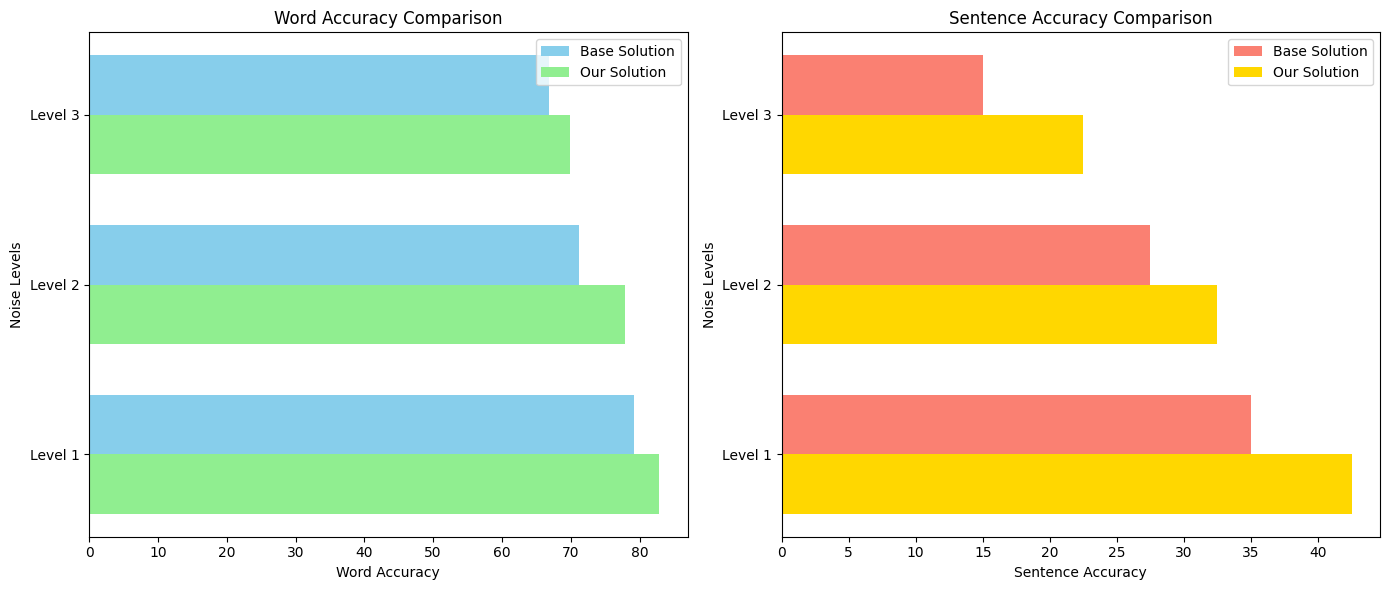

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the solutions and noise levels
levels = ['Level 1', 'Level 2', 'Level 3']
# Replace these with your actual data values
solution1_word_accuracy = [solution1_level1_wa, solution1_level2_wa, solution1_level3_wa]
solution1_sentence_accuracy = [solution1_level1_sa, solution1_level2_sa, solution1_level3_sa]
solution2_word_accuracy = [solution2_level1_wa, solution2_level2_wa, solution2_level3_wa]
solution2_sentence_accuracy = [solution2_level1_sa, solution2_level2_sa, solution2_level3_sa]

# Positions and height for the bars (using y positions for horizontal bar charts)
y = np.arange(len(levels))
bar_height = 0.35  # height of each bar

# Create a figure with two subplots side-by-side
fig, (ax_word, ax_sentence) = plt.subplots(1, 2, figsize=(14, 6))

# --- Word Accuracy Comparison (Horizontal Bars) ---
ax_word.barh(y + bar_height/2, solution1_word_accuracy, bar_height, label='Base Solution', color='skyblue')
ax_word.barh(y - bar_height/2, solution2_word_accuracy, bar_height, label='Our Solution', color='lightgreen')
ax_word.set_ylabel('Noise Levels')
ax_word.set_xlabel('Word Accuracy')
ax_word.set_title('Word Accuracy Comparison')
ax_word.set_yticks(y)
ax_word.set_yticklabels(levels)
ax_word.legend()

# --- Sentence Accuracy Comparison (Horizontal Bars) ---
ax_sentence.barh(y + bar_height/2, solution1_sentence_accuracy, bar_height, label='Base Solution', color='salmon')
ax_sentence.barh(y - bar_height/2, solution2_sentence_accuracy, bar_height, label='Our Solution', color='gold')
ax_sentence.set_ylabel('Noise Levels')
ax_sentence.set_xlabel('Sentence Accuracy')
ax_sentence.set_title('Sentence Accuracy Comparison')
ax_sentence.set_yticks(y)
ax_sentence.set_yticklabels(levels)
ax_sentence.legend()

plt.tight_layout()
plt.show()


#### Useful resources (also included in the archive in moodle):

1. [Possible dataset with N-grams](https://www.ngrams.info/download_coca.asp)
2. [Damerau–Levenshtein distance](https://en.wikipedia.org/wiki/Damerau–Levenshtein_distance#:~:text=Informally%2C%20the%20Damerau–Levenshtein%20distance,one%20word%20into%20the%20other.)